# NREL DATA
## Import Libraries

In [76]:
# Upgrade the Package
!pip install --upgrade pip

# Package from the Python Package Index
!pip install pvlib

# Module netCDF4 was not found 
!pip install netCDF4

# Try to save Excel
!pip install openpyxl

# 4/20/2020: version 1.1.2 released. Code optimization, fix logic so only_use_cftime_datimes=False works as expected (issues #158 and #165). 
!pip install cftime==1.1.2

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1)


In [77]:
# Make basic imports and then set the location and time range data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import seaborn as sns; sns.set_color_codes()
import datetime
import pvlib

# Import pvlib forecast models
from pvlib import solarposition
from pvlib.location import Location
from matplotlib.pyplot import figure
from matplotlib import pyplot
%matplotlib inline

# Specify Location (Denver, CO)
latitude, longitude, tz = 39.7, -105.2, 'America/Denver'
start = pd.Timestamp(datetime.date.today(), tz=tz)
end = start + pd.Timedelta(days=4)


## May's First Week
### Irradiance 

In [78]:
# Read Irradiance data
nrel_df = pd.read_csv('May 11 GHI.txt')
print("Keys of nrel_df: \n{}".format(nrel_df.keys()))

Keys of nrel_df: 
Index(['DATE (MM/DD/YYYY)', 'MST', 'Global Horizontal [W/m^2]'], dtype='object')


In [79]:
# Columns Rename - Remove [ ]
nrel_df = nrel_df.rename(columns = {'Global Horizontal [W/m^2]': 'GHI', 'DATE (MM/DD/YYYY)': 'DATE'})

In [80]:
# Analyzing Data
# Global Horizonal & Direct Normal(W/m*2)
# Air Temperature (deg C)
nrel_df.describe()

,GHI
count,1440.000000
mean,114.848494
std,175.672028
min,0.000000
25%,0.000000
50%,35.383200
75%,143.726250
max,847.653000


In [81]:
# Columns that contain NaN values (True = Nan value)
nrel_df.isnull().any()

DATE    False
MST     False
GHI     False
dtype: bool

In [82]:
nrel_df['Time'] = pd.to_datetime(nrel_df['MST'])

In [83]:
nrel_df['Time'].dt.hour + nrel_df['Time'].dt.minute/60

0        0.000000
1        0.016667
2        0.033333
3        0.050000
4        0.066667
5        0.083333
6        0.100000
7        0.116667
8        0.133333
9        0.150000
10       0.166667
11       0.183333
12       0.200000
13       0.216667
14       0.233333
15       0.250000
16       0.266667
17       0.283333
18       0.300000
19       0.316667
20       0.333333
21       0.350000
22       0.366667
23       0.383333
24       0.400000
25       0.416667
26       0.433333
27       0.450000
28       0.466667
29       0.483333
          ...    
1410    23.500000
1411    23.516667
1412    23.533333
1413    23.550000
1414    23.566667
1415    23.583333
1416    23.600000
1417    23.616667
1418    23.633333
1419    23.650000
1420    23.666667
1421    23.683333
1422    23.700000
1423    23.716667
1424    23.733333
1425    23.750000
1426    23.766667
1427    23.783333
1428    23.800000
1429    23.816667
1430    23.833333
1431    23.850000
1432    23.866667
1433    23.883333
1434    23

In [84]:
nrel_df['Time Float'] = nrel_df['Time'].dt.hour + nrel_df['Time'].dt.minute/60

In [85]:
nrel_df.rename(columns={'Time Float':'Hours', 'MST':'Time', 'Time':'MST'}, inplace=True)

In [86]:
nrel_df.head(10)

,DATE,Time,GHI,MST,Hours
0,5/11/2020,00:00,0.000000,2020-05-12 00:00:00,0.000000
1,5/11/2020,00:01,0.074104,2020-05-12 00:01:00,0.016667
2,5/11/2020,00:02,0.000000,2020-05-12 00:02:00,0.033333
3,5/11/2020,00:03,0.000000,2020-05-12 00:03:00,0.050000
4,5/11/2020,00:04,0.000000,2020-05-12 00:04:00,0.066667
5,5/11/2020,00:05,0.000000,2020-05-12 00:05:00,0.083333
6,5/11/2020,00:06,0.000000,2020-05-12 00:06:00,0.100000
7,5/11/2020,00:07,0.000000,2020-05-12 00:07:00,0.116667
8,5/11/2020,00:08,0.000000,2020-05-12 00:08:00,0.133333
9,5/11/2020,00:09,0.000000,2020-05-12 00:09:00,0.150000


In [87]:
nrel_df.tail(10)

,DATE,Time,GHI,MST,Hours
1430,5/11/2020,23:50,0.037058,2020-05-12 23:50:00,23.833333
1431,5/11/2020,23:51,0.000000,2020-05-12 23:51:00,23.850000
1432,5/11/2020,23:52,0.000000,2020-05-12 23:52:00,23.866667
1433,5/11/2020,23:53,0.000000,2020-05-12 23:53:00,23.883333
1434,5/11/2020,23:54,0.000000,2020-05-12 23:54:00,23.900000
1435,5/11/2020,23:55,0.000000,2020-05-12 23:55:00,23.916667
1436,5/11/2020,23:56,0.000000,2020-05-12 23:56:00,23.933333
1437,5/11/2020,23:57,0.000000,2020-05-12 23:57:00,23.950000
1438,5/11/2020,23:58,0.000000,2020-05-12 23:58:00,23.966667
1439,5/11/2020,23:59,0.000000,2020-05-12 23:59:00,23.983333


In [88]:
nrel_df = nrel_df[["DATE","MST","Time","Hours","GHI"]]

In [89]:
nrel_df.head()

,DATE,MST,Time,Hours,GHI
0,5/11/2020,2020-05-12 00:00:00,00:00,0.000000,0.000000
1,5/11/2020,2020-05-12 00:01:00,00:01,0.016667,0.074104
2,5/11/2020,2020-05-12 00:02:00,00:02,0.033333,0.000000
3,5/11/2020,2020-05-12 00:03:00,00:03,0.050000,0.000000
4,5/11/2020,2020-05-12 00:04:00,00:04,0.066667,0.000000


In [90]:
nrel_df.tail()

,DATE,MST,Time,Hours,GHI
1435,5/11/2020,2020-05-12 23:55:00,23:55,23.916667,0.0
1436,5/11/2020,2020-05-12 23:56:00,23:56,23.933333,0.0
1437,5/11/2020,2020-05-12 23:57:00,23:57,23.950000,0.0
1438,5/11/2020,2020-05-12 23:58:00,23:58,23.966667,0.0
1439,5/11/2020,2020-05-12 23:59:00,23:59,23.983333,0.0


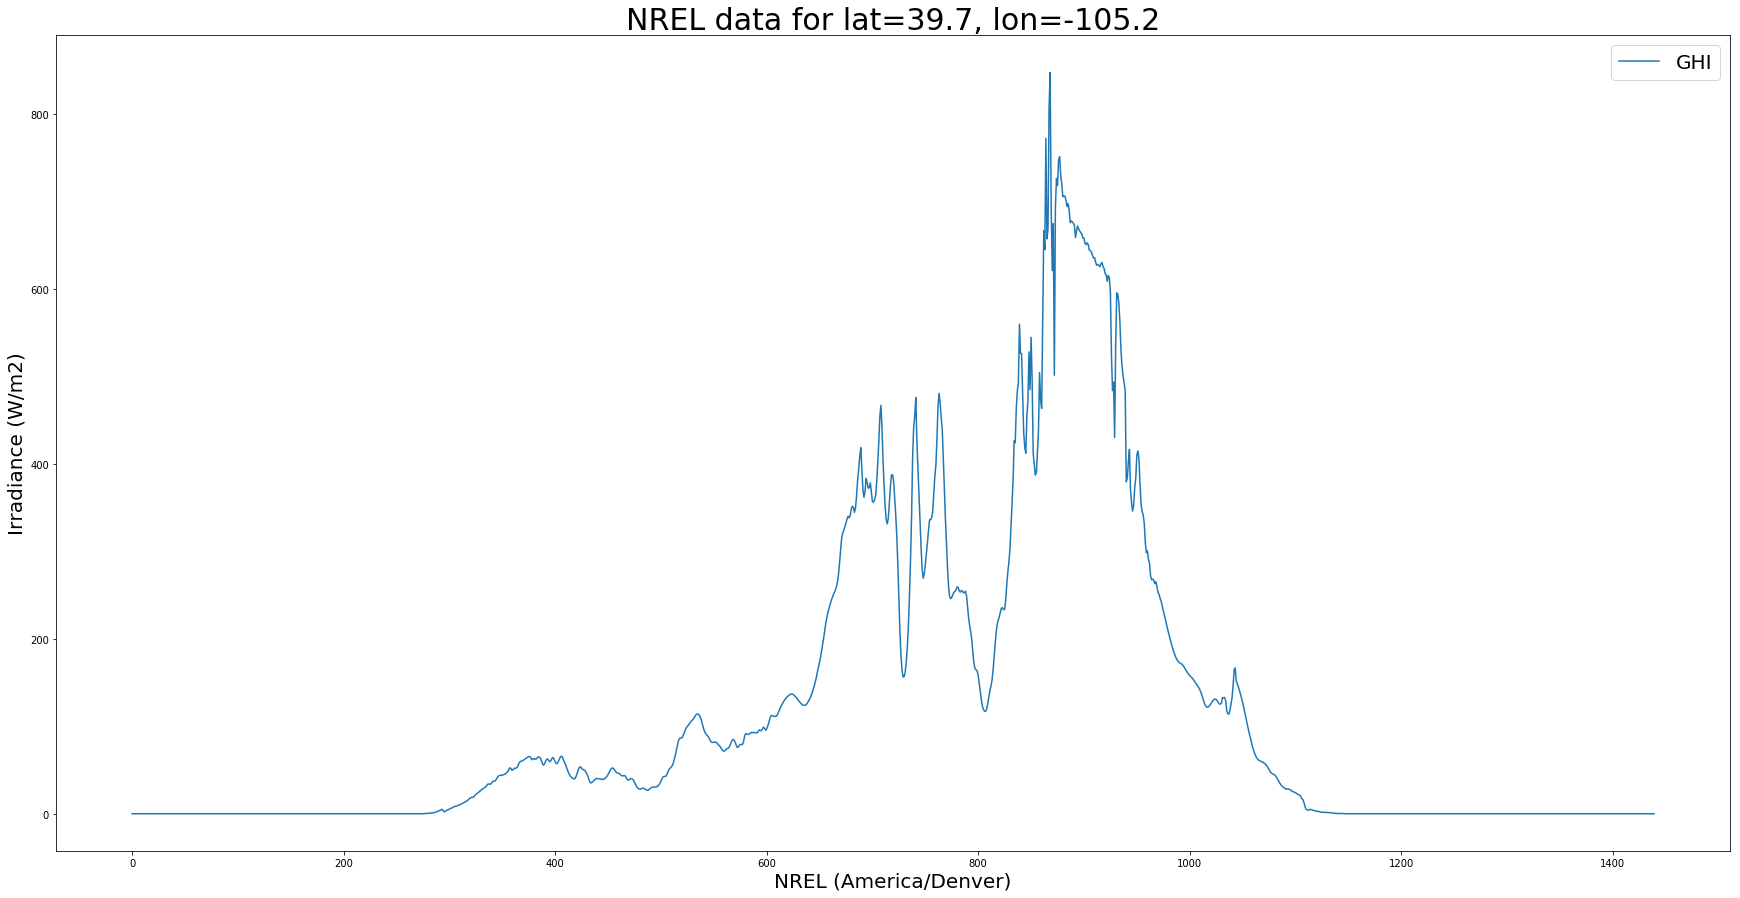

In [91]:
# Plot cloud cover percentages
irrad_var = ['GHI']
nrel_df[irrad_var].plot(figsize=(30,15));
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('NREL ({})'.format(tz),size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

In [92]:
nrel_df_slice = nrel_df.iloc[::15] 

In [93]:
nrel_df_slice

,DATE,MST,Time,Hours,GHI
0,5/11/2020,2020-05-12 00:00:00,00:00,0.00,0.000000
15,5/11/2020,2020-05-12 00:15:00,00:15,0.25,0.000000
30,5/11/2020,2020-05-12 00:30:00,00:30,0.50,0.037056
45,5/11/2020,2020-05-12 00:45:00,00:45,0.75,0.000000
60,5/11/2020,2020-05-12 01:00:00,01:00,1.00,0.000000
75,5/11/2020,2020-05-12 01:15:00,01:15,1.25,0.000000
90,5/11/2020,2020-05-12 01:30:00,01:30,1.50,0.000000
105,5/11/2020,2020-05-12 01:45:00,01:45,1.75,0.000000
120,5/11/2020,2020-05-12 02:00:00,02:00,2.00,0.000000
135,5/11/2020,2020-05-12 02:15:00,02:15,2.25,0.000000


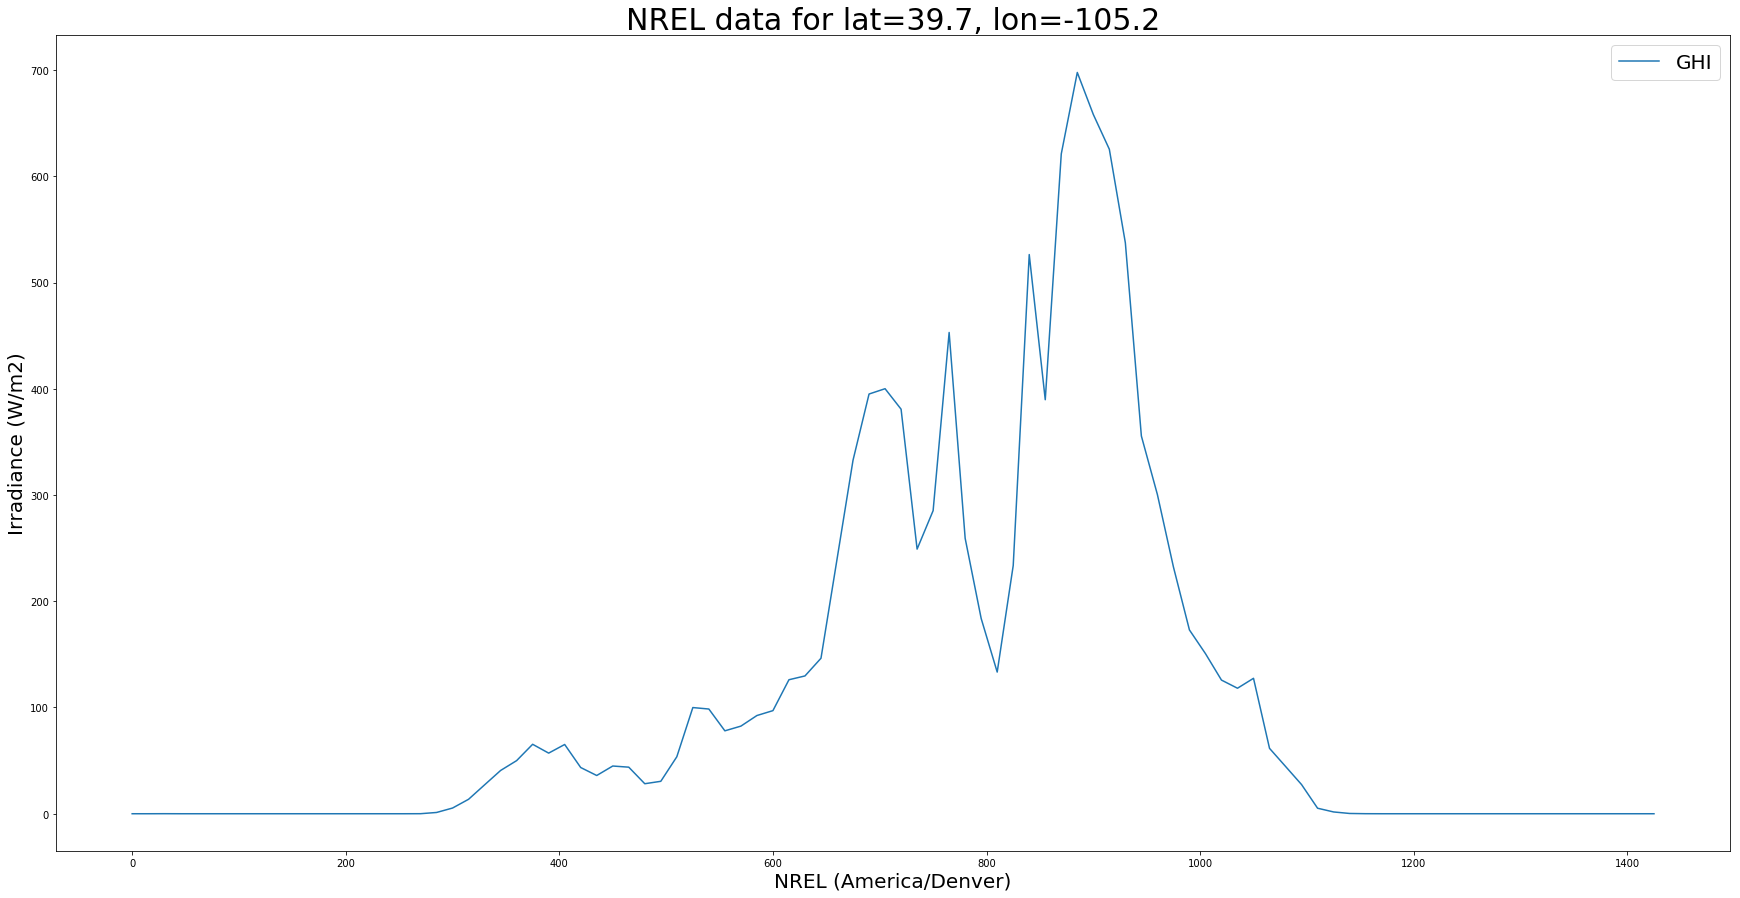

In [94]:
# Plot cloud cover percentages
irrad_var = ['GHI']
nrel_df_slice[irrad_var].plot(figsize=(30,15));
plt.ylabel('Irradiance (W/m2)', size=20);
plt.xlabel('NREL ({})'.format(tz), size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude), size=30);
plt.legend(prop={'size': 20});

In [95]:
nrel_df_ghi = nrel_df_slice['GHI']
nrel_df_ghi

0         0.000000
15        0.000000
30        0.037056
45        0.000000
60        0.000000
75        0.000000
90        0.000000
105       0.000000
120       0.000000
135       0.000000
150       0.000000
165       0.000000
180       0.000000
195       0.000000
210       0.000000
225       0.000000
240       0.000000
255       0.000000
270       0.037069
285       1.186080
300       5.363720
315      13.608100
330      27.200000
345      40.723400
360      49.991100
375      65.373900
390      57.060900
405      65.187800
420      43.498600
435      35.989100
           ...    
990     173.009000
1005    150.728000
1020    125.810000
1035    118.137000
1050    127.477000
1065     61.544100
1080     44.531800
1095     27.447800
1110      5.190800
1125      1.680400
1140      0.251019
1155      0.037044
1170      0.000000
1185      0.000000
1200      0.000000
1215      0.000000
1230      0.000000
1245      0.000000
1260      0.000000
1275      0.000000
1290      0.000000
1305      0.

In [96]:
nrel_df_ac = (nrel_df_ghi * 7648.75 * .1294 * 0.96 * .8 * 0.98 *.9)
nrel_df_ac

0            0.000000
15           0.000000
30          24.843517
45           0.000000
60           0.000000
75           0.000000
90           0.000000
105          0.000000
120          0.000000
135          0.000000
150          0.000000
165          0.000000
180          0.000000
195          0.000000
210          0.000000
225          0.000000
240          0.000000
255          0.000000
270         24.852233
285        795.185643
300       3596.007975
315       9123.301761
330      18235.742528
345      27302.258723
360      33515.618687
375      43828.735605
390      38255.436795
405      43703.968264
420      29162.840806
435      24128.233876
            ...      
990     115990.719818
1005    101052.830874
1020     84347.013510
1035     79202.790994
1050     85464.623171
1065     41261.116240
1080     29855.530850
1095     18401.875506
1110      3480.076923
1125      1126.593446
1140       168.291098
1155        24.835472
1170         0.000000
1185         0.000000
1200      

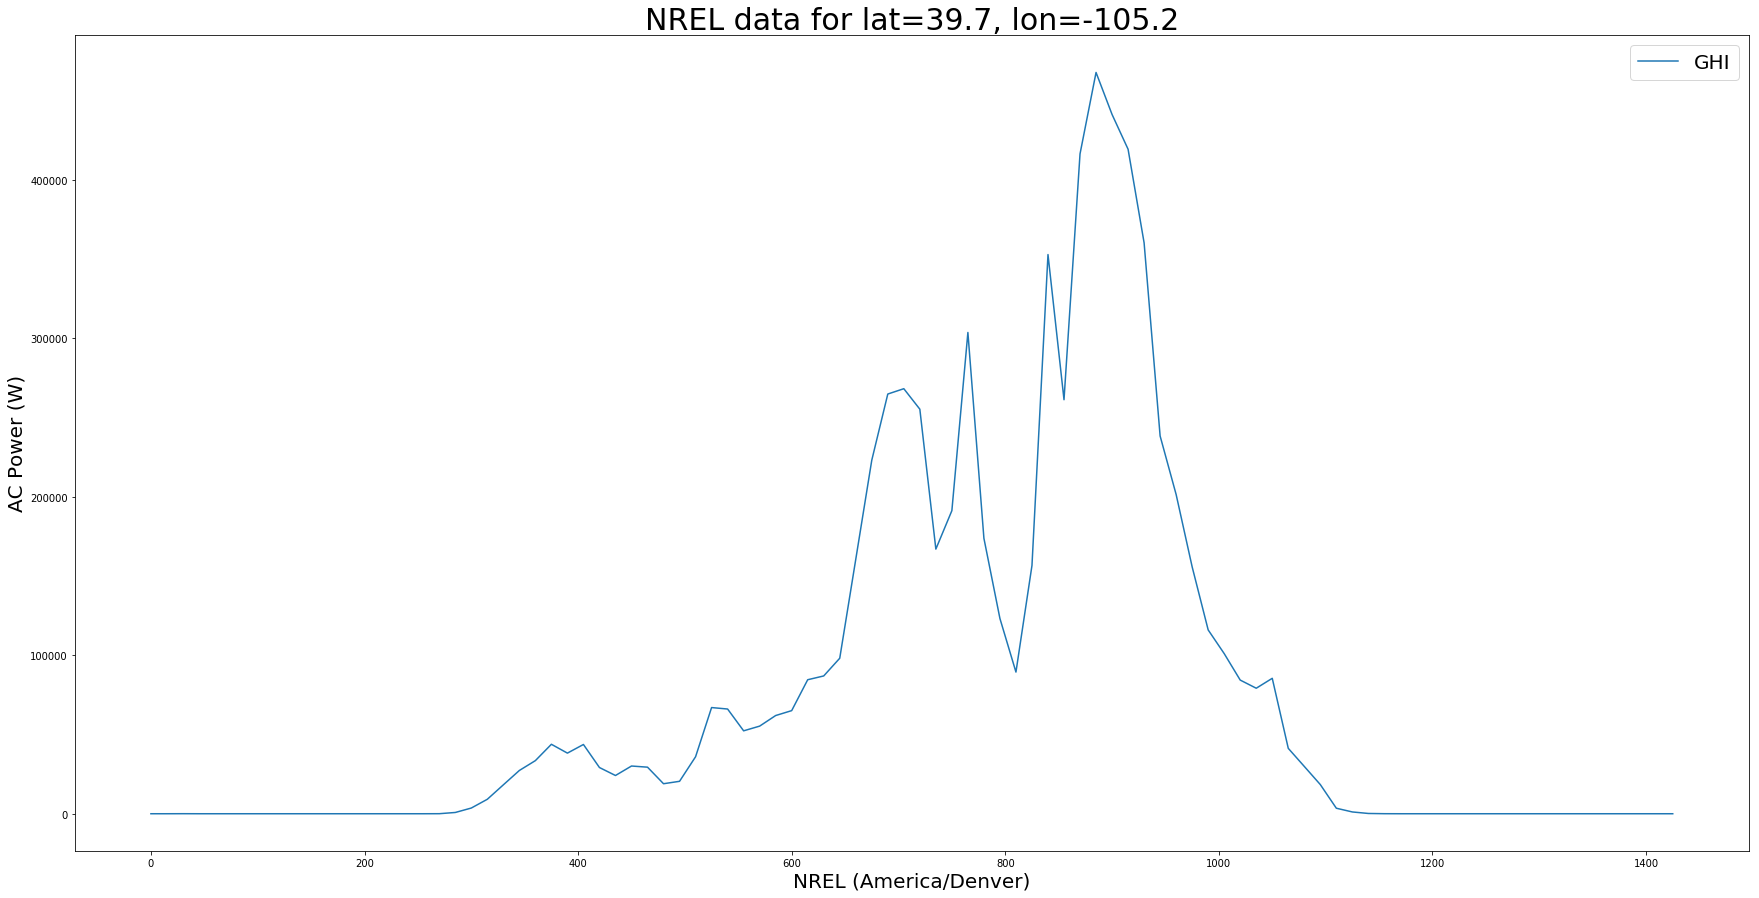

In [97]:
# Plot cloud cover percentages
nrel_df_ac.plot(figsize=(30,15));
plt.ylabel('AC Power (W)', size=20);
plt.xlabel('NREL ({})'.format(tz), size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude), size=30);
plt.legend(prop={'size': 20});

In [98]:
nrel_df_dc = (nrel_df_ghi * 7648.75 * .1294 * .8 * .9)
nrel_df_dc

0            0.000000
15           0.000000
30          26.406800
45           0.000000
60           0.000000
75           0.000000
90           0.000000
105          0.000000
120          0.000000
135          0.000000
150          0.000000
165          0.000000
180          0.000000
195          0.000000
210          0.000000
225          0.000000
240          0.000000
255          0.000000
270         26.416064
285        845.222835
300       3822.287388
315       9697.387076
330      19383.229728
345      29020.257997
360      35624.594693
375      46586.666247
390      40662.666661
405      46454.047899
420      30997.917524
435      25646.507096
            ...      
990     123289.455589
1005    107411.597443
1020     89654.563679
1035     84186.640087
1050     90842.499119
1065     43857.478996
1080     31734.195206
1095     19559.816652
1110      3699.061356
1125      1197.484531
1140       178.880843
1155        26.398249
1170         0.000000
1185         0.000000
1200      

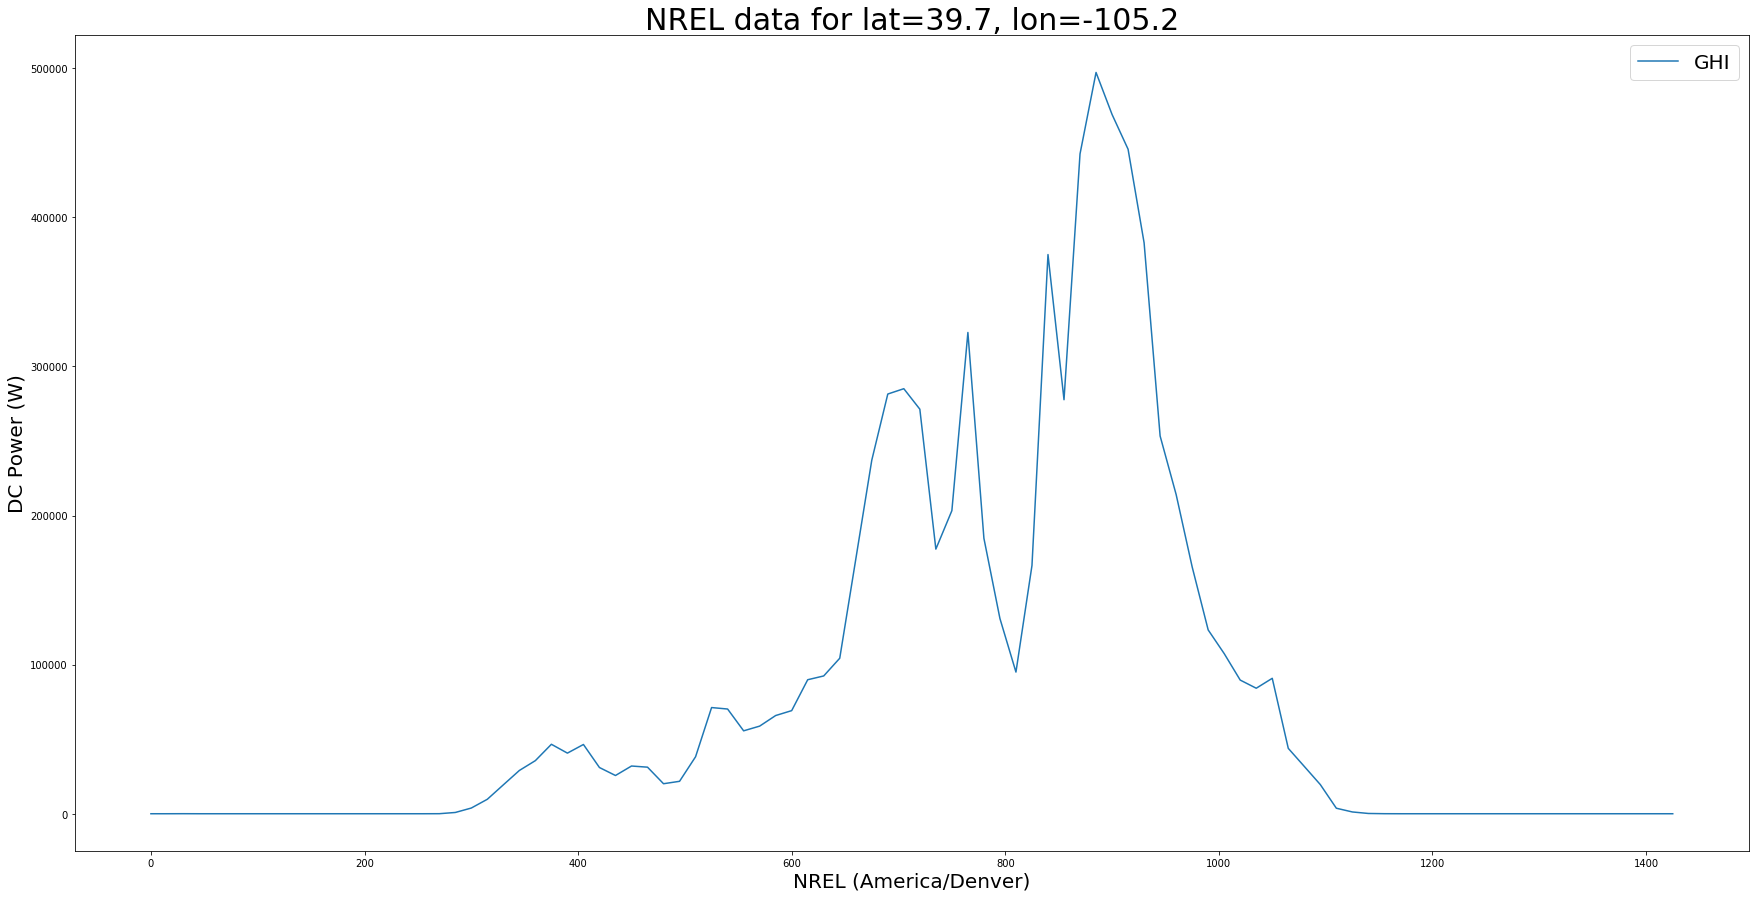

In [99]:
# Plot cloud cover percentages
nrel_df_dc.plot(figsize=(30,15));
plt.ylabel('DC Power (W)', size=20);
plt.xlabel('NREL ({})'.format(tz), size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude), size=30);
plt.legend(prop={'size': 20});

In [100]:
nrel_df_ac.describe()

count        96.000000
mean      76003.466345
std      115951.786719
min           0.000000
25%           0.000000
50%       22295.809924
75%       91581.306883
max      467798.419088
Name: GHI, dtype: float64

In [101]:
nrel_df_dc.describe()

count        96.000000
mean      80785.997390
std      123248.072618
min           0.000000
25%           0.000000
50%       23698.777556
75%       97344.076193
max      497234.714166
Name: GHI, dtype: float64

# PV System
## Design Philosophy
<p>The PVSystem class allows modelers to easily separate the data that represents a PV system from the data that influences the PV system.
<p>The data that represents the PV system is intrinsic. The data that influences the PV system is extrinsic.
<p>Intrinsic data is stored in object attributes. For example, the data that describes a PV system’s module parameters is stored in PVSystem.module_parameters.</p>

## PV System Attributes

In [110]:
# 20 deg tilt, south-facing
system = pvlib.pvsystem.PVSystem(surface_tilt=20, surface_azimuth=180)

In [111]:
print(system.surface_tilt, system.surface_azimuth)

20 180


In [112]:
# call get_aoi with solar_zenith, solar_azimuth
aoi = system.get_aoi(30, 180)

In [113]:
print(aoi)

9.999999999999975


In [114]:
# retrieve_sam returns a dict. the dict keys are module names,
# and the values are model parameters for that module
modules = pvlib.pvsystem.retrieve_sam('cecmod')
module_parameters = modules['Canadian_Solar_Inc__CS5P_220M']
inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
inverter_parameters = inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
system = pvlib.pvsystem.PVSystem(module_parameters=module_parameters, inverter_parameters=inverter_parameters)

In [115]:
# crude numbers from a single module
data = pd.DataFrame({'v_mp': 8, 'v_oc': 10, 'i_mp': 5, 'i_x': 6, 'i_xx': 4, 'i_sc': 7, 'p_mp': 40}, index=[0])
data_scaled = system.scale_voltage_current_power(data)
print(data_scaled)

   v_mp  v_oc  i_mp  i_x  i_xx  i_sc  p_mp
0     8    10     5    6     4     7    40


# Model Chain
## Example - Import Libraries

In [116]:
# Import pvlib
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.tracking import SingleAxisTracker
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

In [118]:
# Load some module and inverter specifications
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
sandia_module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
cec_inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# model a big tracker for more fun
tracker = SingleAxisTracker(module_parameters=module, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=15, strings_per_inverter=300)

# Create Location object, a PVSystem and a ModuleChain
location = Location(latitude=39.7, longitude=-105.2)
system = PVSystem(surface_tilt=20, surface_azimuth=200, module_parameters=sandia_module, inverter_parameters=cec_inverter, temperature_model_parameters=temperature_model_parameters)

# fx is a common abbreviation for forecast
fx_model = GFS()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)

In [119]:
# Print the Model Chain
print(mc)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses


In [43]:
# Specify time range
start = pd.Timestamp(datetime.date.today(), tz=tz)
end = start + pd.Timedelta(days=4)
irrad_vars = ['ghi','dni','dhi']

# Run Model with simple Data 
weather = pd.DataFrame([[1050, 1000, 100, 30, 5]], columns=['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed'], index=[pd.Timestamp('20200505 1200', tz='America/Denver')])
mc.run_model(weather);

In [44]:
mc.aoi

2020-05-05 12:00:00-06:00    20.811958
Name: aoi, dtype: float64

In [45]:
mc.cell_temperature

2020-05-05 12:00:00-06:00    57.299137
dtype: float64

In [46]:
mc.dc

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
2020-05-05 12:00:00-06:00,5.345029,4.737896,52.390973,40.746596,193.05312,5.224805,3.327979


In [47]:
mc.ac

2020-05-05 12:00:00-06:00    185.930384
dtype: float64

# PV Power Forecast

In [48]:
# fx is a common abbreviation for forecast
fx_model = GFS()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)

NameError: name 'GFS' is not defined

### ModelChain Attributes

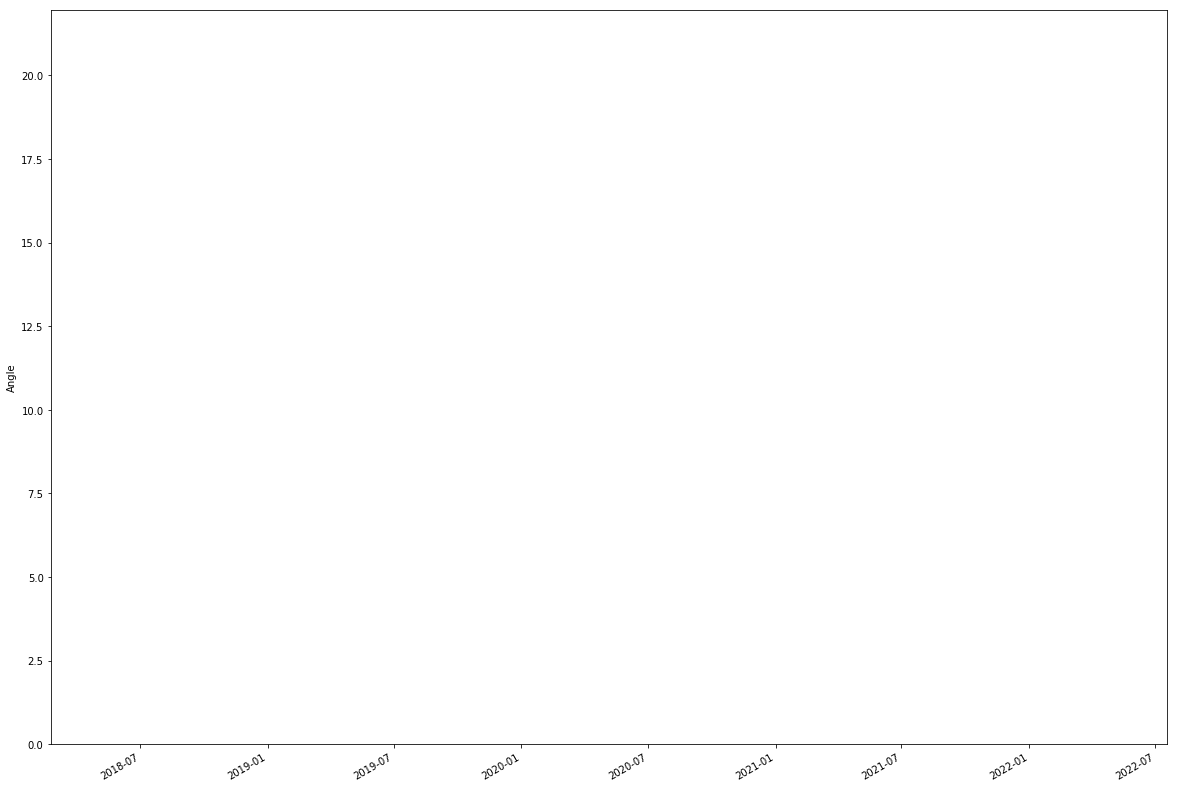

In [49]:
# ModelChain sotres modeling results on a series of attributes. 
# Angle of Incidence
mc.aoi.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('Angle');

In [50]:
## Modeling intermediates & Forecast Power

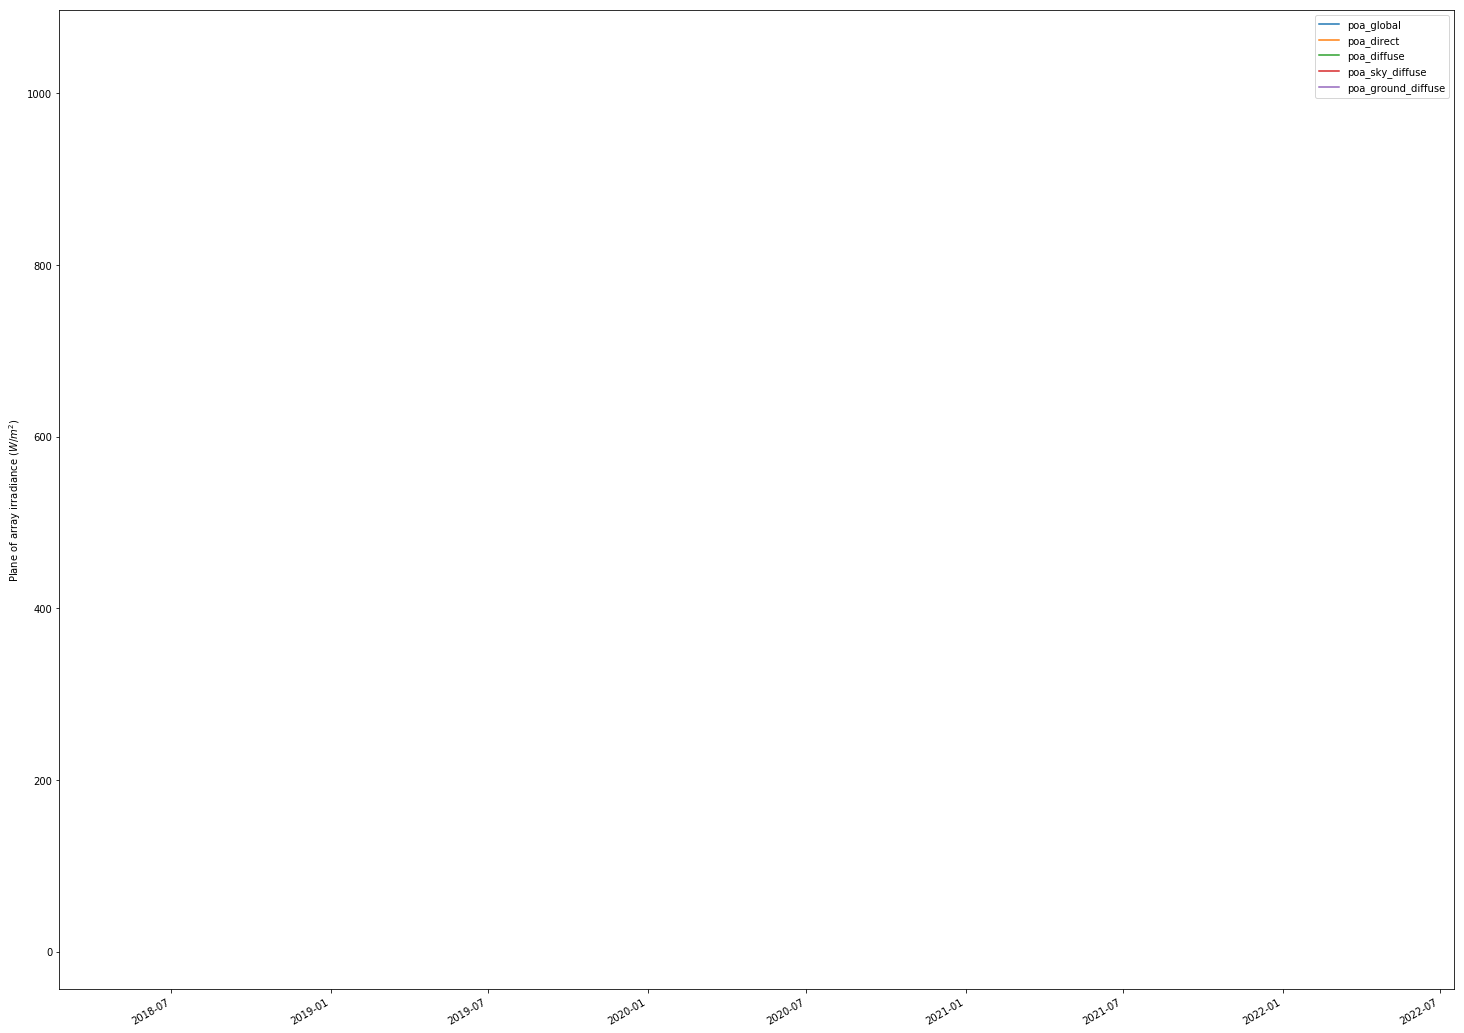

In [51]:
mc.total_irrad.plot(figsize=(25,20));
plt.ylabel('Plane of array irradiance ($W/m^2$)');
plt.legend(loc='best');

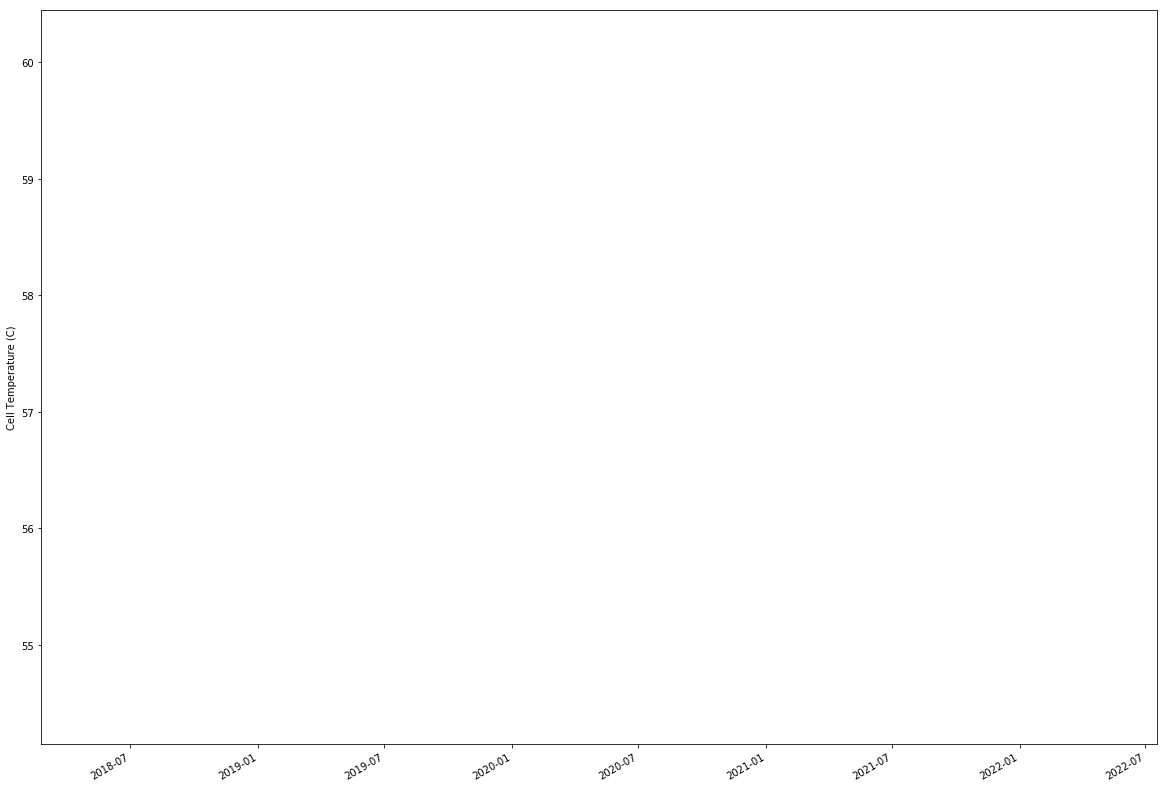

In [52]:
# Cell and module temperature
mc.cell_temperature.plot(figsize=(20,15));
plt.ylabel('Cell Temperature (C)');

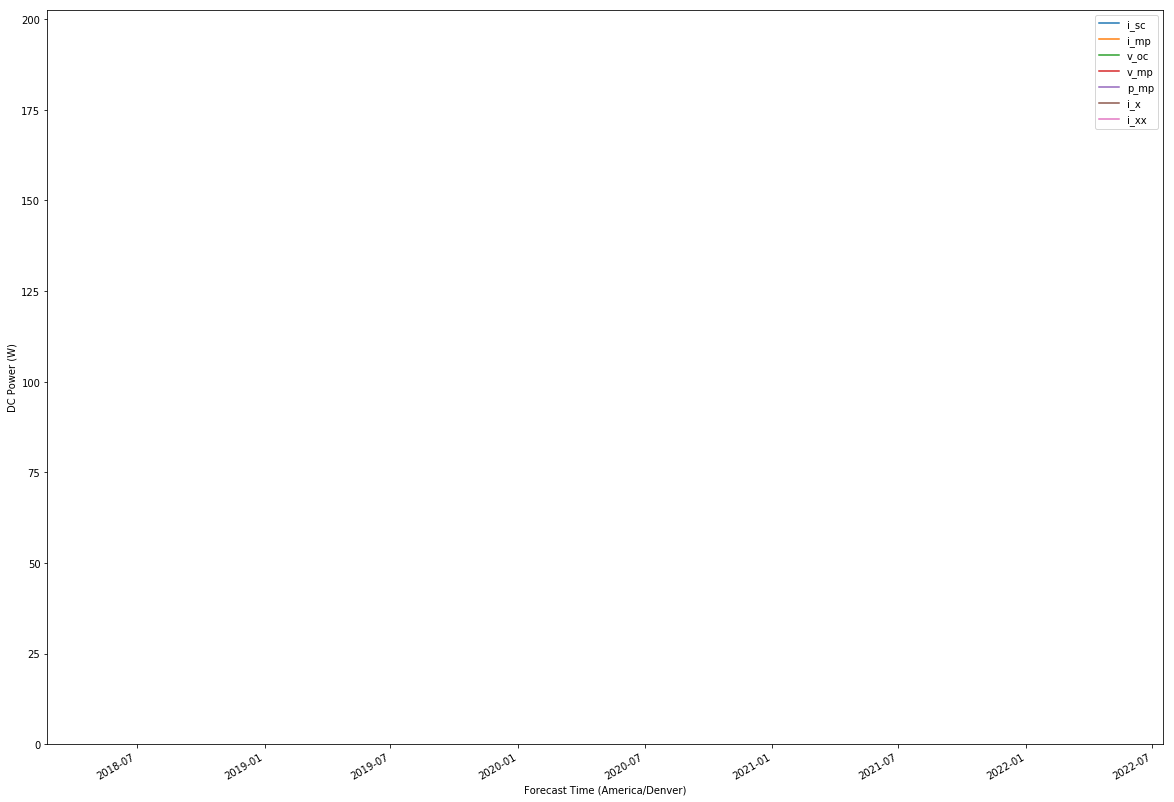

In [53]:
mc.dc.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('DC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [54]:
mc.dc.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
mean,5.345029,4.737896,52.390973,40.746596,193.05312,5.224805,3.327979
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.345029,4.737896,52.390973,40.746596,193.05312,5.224805,3.327979
25%,5.345029,4.737896,52.390973,40.746596,193.05312,5.224805,3.327979
50%,5.345029,4.737896,52.390973,40.746596,193.05312,5.224805,3.327979
75%,5.345029,4.737896,52.390973,40.746596,193.05312,5.224805,3.327979
max,5.345029,4.737896,52.390973,40.746596,193.05312,5.224805,3.327979


In [55]:
mc.dc.fillna(0)

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
2020-05-05 12:00:00-06:00,5.345029,4.737896,52.390973,40.746596,193.05312,5.224805,3.327979


In [56]:
mc.dc.fillna(0).to_csv('5 min DC.csv', encoding='utf-8')

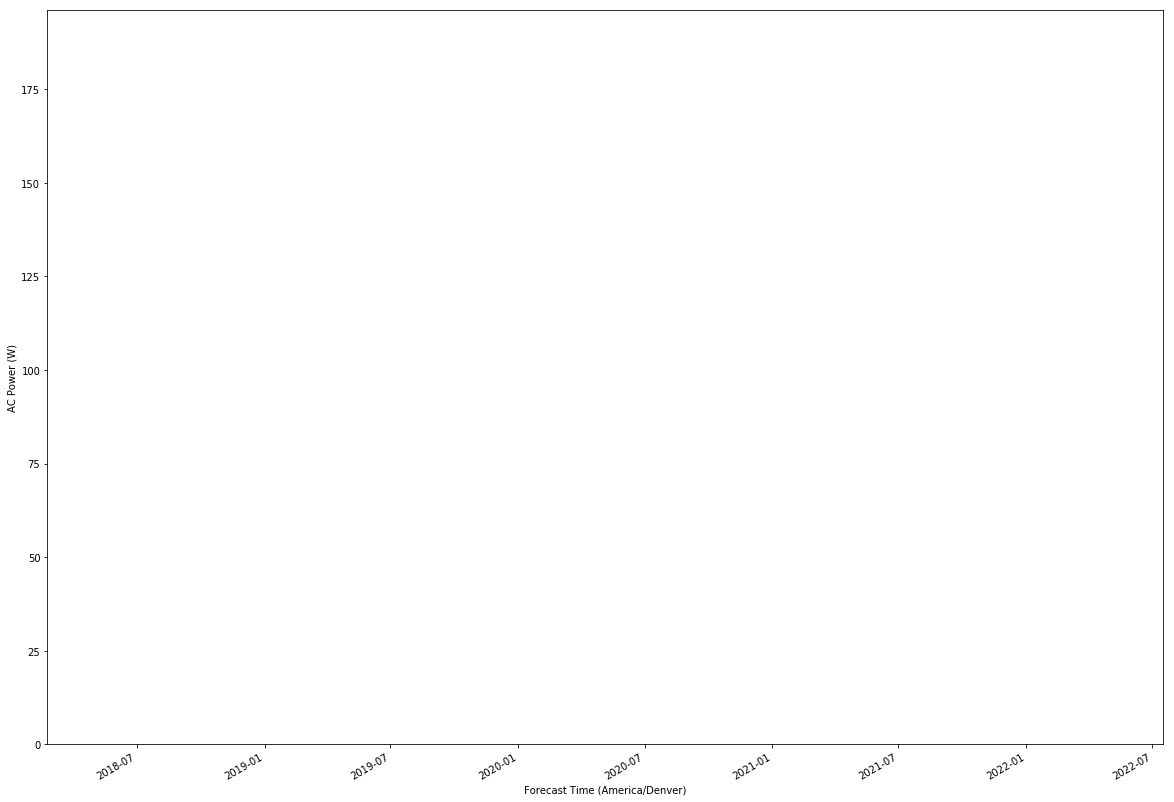

In [57]:
# AC Power
mc.ac.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('AC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [58]:
mc.ac.fillna(0)

2020-05-05 12:00:00-06:00    185.930384
dtype: float64

In [59]:
mc.ac.describe()

count      1.000000
mean     185.930384
std             NaN
min      185.930384
25%      185.930384
50%      185.930384
75%      185.930384
max      185.930384
dtype: float64

In [60]:
mc.ac.fillna(0).to_csv('5 min AC.csv', encoding='utf-8')